In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

100 630


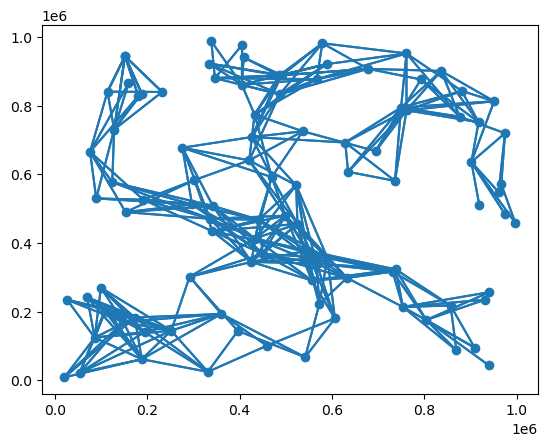

In [3]:
deep_reload(nice)

rng = np.random.default_rng(26893751)

kw = {
    'rng': rng,
    'xlim': (0, 1e6),
    'ylim': (0, 1e6),
}

atlas = nice.graph.nmu_graph(100, 3, **kw)

conditions = [
    lambda e: e['distance'] <= 250e3,
    lambda e: e['distance'] >= 100e3,
]

graph_o = nice.graph.all_pairs_graph(atlas, conditions)

print(graph_o.number_of_nodes(), graph_o.number_of_edges())

fig, ax = plt.subplots()

_ = nice.plot.plot_graph(graph_o, nodes = {}, edges = {}, ax = ax)

In [158]:
np.exp(np.arange(0, 10, 1)) - 1

array([0.00000000e+00, 1.71828183e+00, 6.38905610e+00, 1.90855369e+01,
       5.35981500e+01, 1.47413159e+02, 4.02428793e+02, 1.09563316e+03,
       2.97995799e+03, 8.10208393e+03])

In [166]:
'''
Preparing the graph
'''
deep_reload(nice)

graph = graph_o.copy()

n = 15

rng = np.random.default_rng(26589763514)

places = rng.choice(graph.nodes, replace = False, size = n)
stations = list(set(graph.nodes) - set(places))

'''
Adding classes
'''

for place in places:

    graph._node[place]['_class'] = 'Place'

for station in stations:

    volumes = np.exp(np.arange(0, 10, 2)) - 1
    delays = np.exp(volumes)

    graph._node[station]['_class'] = 'Station'
    graph._node[station]['volumes'] = volumes
    graph._node[station]['delays'] = volumes ** 2
    

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['_class'] = 'Path'

'''
Adding demands
'''
for place in places:

    destinations = set(places) - set([place])

    graph._node[place]['demand'] = {p: rng.uniform(0, 1) for p in destinations}

'''
Adding time to links
'''
for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['speed'] = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / edge['speed']

'''
Making direct path links
'''
for origin in places:

    path = nx.shortest_path(graph, source = origin, weight = 'time')

    for destination in places:

        costs = nice.graph.path_cost(
            graph, path[destination], fields = ['distance', 'time']
        )
        
        costs['time'] *= 2
        # costs['capacity'] = .1
        
        graph.add_edge(origin, destination, **costs, _class = 'Path')
        
print(graph.number_of_nodes(), graph.number_of_edges())

100 847


In [167]:
'''
Building the network
'''
deep_reload(nice)

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph)

network.build()

network.size()

Graph Transformed: 0.012027263641357422
Parameters Built: 0.002313852310180664
Variables Built: 0.43348121643066406
Constraints Built: 0.04299187660217285
Objective Built: 0.016693115234375


ModelSizeReport(activated = Bunch(binary_variables = 0, constraints = 1693, continuous_variables = 4600, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 4600), overall = Bunch(binary_variables = 0, constraints = 1693, continuous_variables = 12990, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 12990), warning = Bunch(unassociated_disjuncts = 0))

In [168]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'cbc',
    },
}

network.solve(**kw)
solution = network.solution

Problem Solved: 0.2505772113800049
Results Collected: 0.018957138061523438


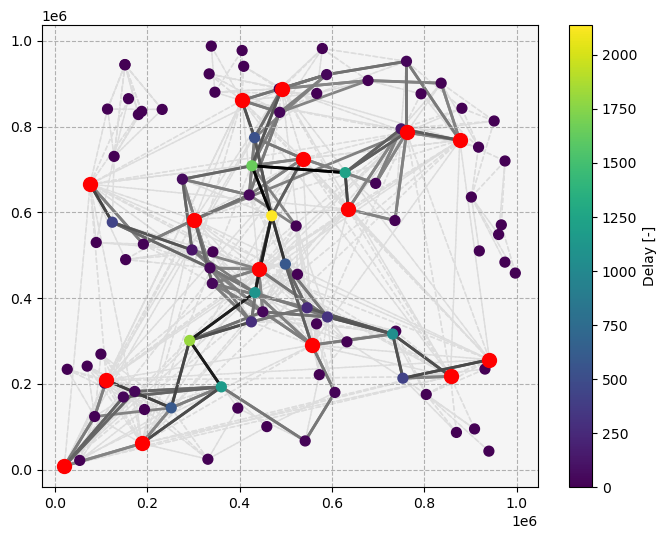

In [169]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

selection = (
    [(s, t) for s, a in solution._adj.items() for t, e in a.items() if e['total_flow'] > 0]
)

kw = {
    'nodes': {
        'field': 'delay',
        'plot': {
            's': 50,
            'zorder': 2,
        },
        'colorbar': {
            'label': 'Delay [-]',
        },
    },
    'edges': {
        'field': 'total_flow',
        'selection': selection,
        'cmap': nice.plot.Colormap(['#888888', '#000000']),
        'plot': {
            'lw': 2,
            'color': 'gray',
            'zorder': 1,
        },
    },
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'plot': {
            's': 100,
            'fc': 'r',
            'zorder': 3,
        },
    },
    'edges': {
        'plot': {
            'lw': 1,
            'ls': '--',
            'color': '#dddddd',
            'zorder': 0,
        },
    },        
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

In [170]:
import pyomo.environ as pyomo

pyomo.value(network.model.objective)

3184140.0977322585

In [175]:
'''
Solving the model
'''
# deep_reload(nice)

kw = {
    'solver': {
        '_name': 'cbc',
    },
}

network.model.scale = 1000

network.solve(**kw)
solution = network.solution

Problem Solved: 0.4014420509338379
Results Collected: 0.02693772315979004


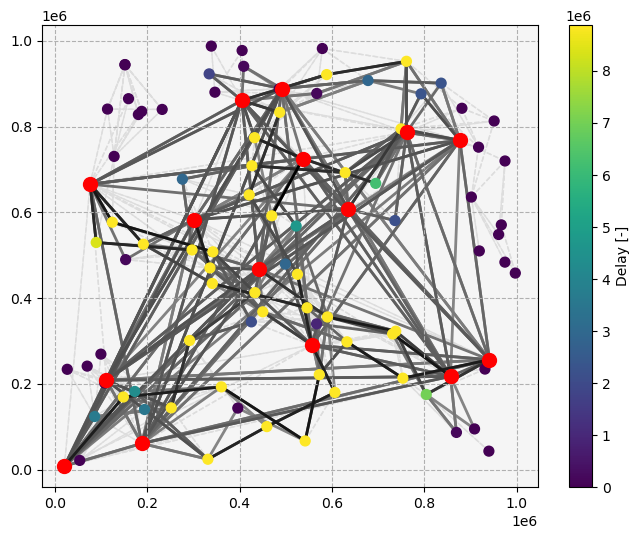

In [176]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

selection = (
    [(s, t) for s, a in solution._adj.items() for t, e in a.items() if e['total_flow'] > 0]
)

kw = {
    'nodes': {
        'field': 'delay',
        'plot': {
            's': 50,
            'zorder': 2,
        },
        'colorbar': {
            'label': 'Delay [-]',
        },
    },
    'edges': {
        'field': 'total_flow',
        'selection': selection,
        'cmap': nice.plot.Colormap(['#888888', '#000000']),
        'plot': {
            'lw': 2,
            'color': 'gray',
            'zorder': 1,
        },
    },
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'plot': {
            's': 100,
            'fc': 'r',
            'zorder': 3,
        },
    },
    'edges': {
        'plot': {
            'lw': 1,
            'ls': '--',
            'color': '#dddddd',
            'zorder': 0,
        },
    },        
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)